# Exploring Wine through Machine Learning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline
sns.set()

**Loading in our first dataset**

In [2]:
firstdata = pd.read_csv('../Project/winemag-data_first150k.csv')

In [3]:
len(firstdata)

150930

**Loading in the second dataset**

In [4]:
seconddata = pd.read_csv('../Project/winemag-data-130k-v2.csv')

In [5]:
len(seconddata)

129971

**Merging both datasets together to create one large CSV with all our values**

In [6]:
data = pd.merge(firstdata, seconddata, how="outer")
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,taster_name,taster_twitter_handle,title
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,NaN,NaN,NaN
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,NaN,NaN,NaN
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,NaN,NaN,NaN
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,NaN,NaN,NaN
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,NaN,NaN,NaN


In [7]:
len(data)

280900

**Seeing if there are any duplicate descriptions.**

In [8]:
data[data.duplicated('description',keep=False)].sort_values('description').head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,taster_name,taster_twitter_handle,title
245284,94355,Austria,"""Chremisa,"" the ancient name of Krems, is comm...",Edition Chremisa Sandgrube 13,85,24.0,Niederösterreich,NaN,NaN,Grüner Veltliner,Winzer Krems,Roger Voss,@vossroger,Winzer Krems 2011 Edition Chremisa Sandgrube 1...
96052,96052,Austria,"""Chremisa,"" the ancient name of Krems, is comm...",Edition Chremisa Sandgrube 13,85,24.0,Niederösterreich,NaN,NaN,Grüner Veltliner,Winzer Krems,NaN,NaN,NaN
277812,126883,US,$10 for this very drinkable Cab? That's crazy....,NaN,87,10.0,California,North Coast,North Coast,Cabernet Sauvignon,Line 39,Virginie Boone,@vboone,Line 39 2009 Cabernet Sauvignon (North Coast)
83019,83019,US,$10 for this very drinkable Cab? That's crazy....,NaN,87,10.0,California,North Coast,North Coast,Cabernet Sauvignon,Line 39,NaN,NaN,NaN
147725,147725,Chile,$11. Opens with a highly perfumed bouquet of l...,Estate Reserve,84,11.0,Maipo Valley,NaN,NaN,Chardonnay,La Playa,NaN,NaN,NaN


**First we drop any instances of duplicate descriptions.  Second, we remove the instances where the price data is incomplete.  Third, we remove the generic blends that are prominent in the dataset.**

In [9]:
data = data.drop_duplicates('description')
data = data[pd.notnull(data.price)]
data = data[data.variety !='Rosé']
data = data[data.variety !='Bordeaux-style Red Blend']
data = data[data.variety !='Red Blend']
data.shape

(136033, 14)

In [10]:
len(data)

136033

**Making wine varieties consistent.  Converting all language variants to English.**

In [11]:
data['variety'] = data['variety'].replace(['weissburgunder'], 'chardonnay')
data['variety'] = data['variety'].replace(['spatburgunder'], 'pinot noir')
data['variety'] = data['variety'].replace(['grauburgunder'], 'pinot gris')
data['variety'] = data['variety'].replace(['garnacha'], 'grenache')
data['variety'] = data['variety'].replace(['pinot nero'], 'pinot noir')
data['variety'] = data['variety'].replace(['alvarinho'], 'albarino')

**Looking at the distribution of variety in the dataset.**

In [12]:
data['variety'].value_counts()

Pinot Noir                       15986
Chardonnay                       14795
Cabernet Sauvignon               13124
Sauvignon Blanc                   6555
Riesling                          6277
Syrah                             5740
Merlot                            4687
Zinfandel                         3796
Malbec                            3353
Sangiovese                        3196
White Blend                       2858
Nebbiolo                          2520
Portuguese Red                    2517
Tempranillo                       2469
Sparkling Blend                   2441
Rhône-style Red Blend             1791
Pinot Gris                        1654
Shiraz                            1650
Cabernet Franc                    1603
Champagne Blend                   1576
Viognier                          1395
Pinot Grigio                      1375
Grüner Veltliner                  1265
Gewürztraminer                    1177
Portuguese White                  1082
Petite Sirah             

In [13]:
len(data.variety.unique())

743

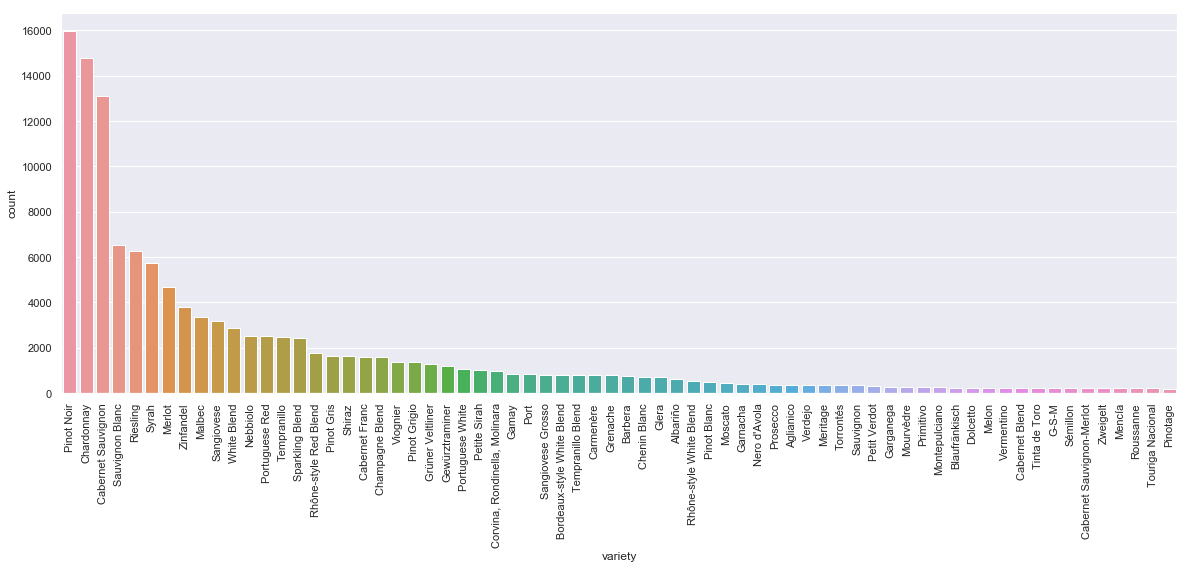

In [14]:
data = data.groupby('variety').filter(lambda x: len(x) >200)
list = data.variety.value_counts().index.tolist()
fig4, ax4 = plt.subplots(figsize = (20,7))
sns.countplot(x='variety', data=data, order = list, ax=ax4)
plt.xticks(rotation = 90)
plt.show()

**The plan is to predict the wine variety based on description.  After diving deeper into the varieties, we find that there are 746 unique values.  It will be extremely difficult to train a classifier to predict all of those.  Because of this I will have to simplify the amount of varieties.  Going forward I plan on only using the varieties that have more than 3000 instances (or the top ten) to give the model a more realistic chance of predicting the correct label.**

In [15]:
data = data.groupby('variety').filter(lambda x: len(x) > 3000)

In [16]:
len(data)

77509

# Machine Learning Models

* Logistic Regression
* K-Means Clustering
* Random Forest

# Logistic Regression:

* First step is to drop the unneeded features (columns), and reduce the dimensionality of our data to perform a logistic regression.  We will only be using description to predict the variety of wine. 
<br> 
* The accuracy score was suprisingly high after the initial test.  The model predicted the correct variety of wine based on description with 80% accuracy.  After some thinking and a deep dive into the data, I realized that the description actually has the variety of wine in it a lot of times.  This takes away from the purpose of the model, so before training I must remove these indicator words and re-run the model updating the TfidfVectorizer() function with our stop_words.  The description column also has to be refined.  Right now our model is using the full feature space with all stop words, indicators, and punctuation.  Ideally these three types of tokens should be removed.  This will reduce dimensionality further and allow the model to give extra weight to more important tokens.

### Price:
**Looking at average price for each wine variety to see if it would be a viable feature to add.**

In [17]:
price_df = pd.DataFrame(data.groupby(['variety'])['price'].agg(lambda x: x.unique().mean()))
price_df = price_df.reset_index()
price_df = price_df.sort_values(by=['price'], ascending=False)

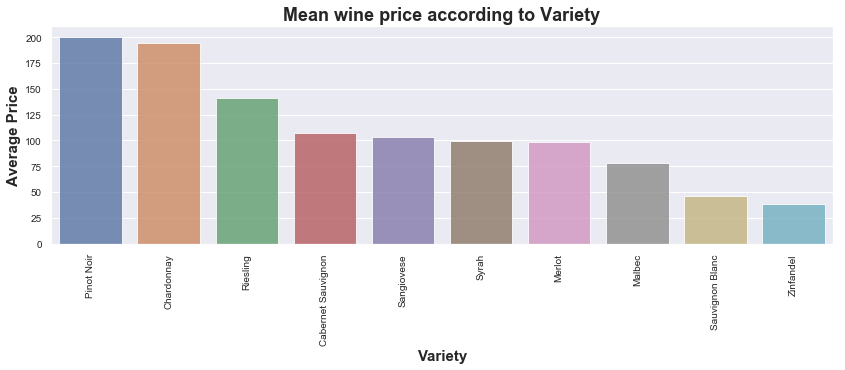

In [18]:
plt.figure(figsize=(14,4))
sns.barplot(x='variety',y='price',data=price_df, alpha=0.8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Mean wine price according to Variety',fontweight="bold", size=18)
plt.ylabel('Average Price', fontsize = 15, fontweight="bold")
plt.xlabel('Variety', fontsize = 15, fontweight="bold")
plt.xticks(rotation = 90)
plt.show()

**After Looking at the distribution I decided to add this feature to my first logistic regression. 
<br>
<br>
With this feature added we only increased the accuracy of our model by 1%.  Therefore it was determined to have no significance in determining variety, and was removed from the model.**

### Polishing the Descriptions (Reducing Dimensionality)

#### Removing indicator words

In [19]:
wines = data.variety.unique().tolist()
wines.sort()
wines

['Cabernet Sauvignon',
 'Chardonnay',
 'Malbec',
 'Merlot',
 'Pinot Noir',
 'Riesling',
 'Sangiovese',
 'Sauvignon Blanc',
 'Syrah',
 'Zinfandel']

#### Splitting each indicator and removing capitalization
* Initializing as a set becuase set elements are unique and duplicates are not allowed.
* This set will be added to the list of stop_words to remove from the description.

In [20]:
words = set() 
for x in data.variety:
    x = x.lower()
    x = x.split()
    for word in x:
        words.add(word)

indicators = sorted(words)
indicators

['blanc',
 'cabernet',
 'chardonnay',
 'malbec',
 'merlot',
 'noir',
 'pinot',
 'riesling',
 'sangiovese',
 'sauvignon',
 'syrah',
 'zinfandel']

#### Stop_words and punctuation
* First we create a list of punctuations to later remove.
* We also import a list of english stopwords (from nltk.corups) to ignore.
* Lastly, we update our stop_words variable (ignore), with the punctuation, english stop words, and indicators.

In [21]:
punctuation = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', 'cab',"%"]
ignore = set(stopwords.words('english'))
ignore.update(indicators)
ignore.update(punctuation)

### Training the Model

In [22]:
feature = data.description
labels = data.variety

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(feature, labels,test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(62007,) (15502,) (62007,) (15502,)


**Using the TF-IDF Vectorizer:**
<br>
This unique vectorizer has some advantages over the simple count vectorizer.  It increases the value proportionally to count, and offsets the frequency of the word in the corpus as a whole.  This helps us with frequent words that may not hold as much weight for our predictive model.

In [24]:
tfidf_vec = TfidfVectorizer(stop_words=ignore)
X_train = tfidf_vec.fit_transform(X_train.values)
X_test = tfidf_vec.transform(X_test.values)

In [25]:
# Reference: https://www.kaggle.com/carkar/classifying-wine-type-by-review
dic = {}
for wine in wines:
    lgr = linear_model.LogisticRegression()
    y = Y_train == wine
    lgr.fit(X_train, y)
    dic[wine] = lgr

testing_probs = pd.DataFrame(columns = wines)
training_probs = pd.DataFrame(columns = wines)

**Analyzing the Accuracy**

In [26]:
# Reference: https://www.kaggle.com/carkar/classifying-wine-type-by-review
for wine in wines:
    testing_probs[wine] = dic[wine].predict_proba(X_test)[:,1]
    training_probs[wine] = dic[wine].predict_proba(X_train)[:,1]
    
predicted_wine_test = testing_probs.idxmax(axis=1)
predicted_wine_train = training_probs.idxmax(axis=1)

comparison = pd.DataFrame({'Actual':Y_test.values, 'Predicted':predicted_wine_test.values})   

score = cross_val_score(lgr, X_train,Y_train, scoring= 'accuracy')

print("Training accuracy:",accuracy_score(Y_train, predicted_wine_train)*100,"%")
print('Testing accuracy:',accuracy_score(Y_test, predicted_wine_test)*100,"%")
print('Cross Validation Score:',score)

comparison.head(10)

Training accuracy: 77.13161417259342 %
Testing accuracy: 71.77783511804928 %
Cross Validation Score: [0.70389899 0.70700082 0.70608729]


,Actual,Predicted
0,Pinot Noir,Pinot Noir
1,Cabernet Sauvignon,Pinot Noir
2,Chardonnay,Chardonnay
3,Pinot Noir,Pinot Noir
4,Cabernet Sauvignon,Cabernet Sauvignon
5,Chardonnay,Chardonnay
6,Chardonnay,Chardonnay
7,Syrah,Syrah
8,Chardonnay,Chardonnay
9,Sauvignon Blanc,Pinot Noir


**After removing all the stopwords, punctuation, and indicators our accuracy realistically dropped from 80% to 72%.  There could be room for more refinement.  Although, 72% is still a really good accuracy score for our model.**

#### Analyzing the Confusion Matrix

In [27]:
label_names = ['Cabernet Sauvignon',
 'Chardonnay',
 'Malbec',
 'Merlot',
 'Pinot Noir',
 'Riesling',
 'Sangiovese',
 'Sauvignon Blanc',
 'Syrah',
 'Zinfandel']

confusion_matrix = confusion_matrix(Y_test, predicted_wine_test)

# Reference: https://gist.github.com/nickynicolson/202fe765c99af49acb20ea9f77b6255e

def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

cm2df(confusion_matrix, label_names)

,Cabernet Sauvignon,Chardonnay,Malbec,Merlot,Pinot Noir,Riesling,Sangiovese,Sauvignon Blanc,Syrah,Zinfandel
Cabernet Sauvignon,2043,25,90,67,315,2,22,6,103,33
Chardonnay,6,2675,0,0,46,89,2,104,3,1
Malbec,201,14,254,14,127,2,2,3,47,5
Merlot,409,16,34,108,221,3,26,6,58,11
Pinot Noir,164,45,29,25,2811,15,5,13,40,14
Riesling,0,174,0,0,20,1053,0,46,0,0
Sangiovese,88,10,6,6,126,1,378,0,22,6
Sauvignon Blanc,8,348,0,0,12,71,1,927,1,1
Syrah,299,16,49,20,214,2,14,5,469,28
Zinfandel,115,13,2,9,119,0,3,0,57,409


**We have the most data on Chardonnay, 14795 instances in the original dataframe.  This makes it easier for our classifier to learn and make more accurate descriptions with the extra information.  As we can see below our logistic regression has a 91% chance of predicting Chardonnay correctly.**

In [28]:
chardonnay = confusion_matrix[1, 1]
sum_chardonnay = confusion_matrix[1, :].sum()
print('Our classifier predicts "Chardonnay" with ' + str(float(chardonnay) / float(sum_chardonnay)*100),"% " + 'accuracy.')

Our classifier predicts "Chardonnay" with 91.42173615857826 % accuracy.


**However, this model is atrociously bad at predicting Merlot and Malbec.**

In [29]:
Malbec = confusion_matrix[2, 2]
sum_Malbec = confusion_matrix[2, :].sum()
Merlot = confusion_matrix[3, 3]
cs_mer = confusion_matrix[3,0]
cs_mal = confusion_matrix[2,0]
sum_Merlot = confusion_matrix[3, :].sum()
print('Our classifier predicts "Merlot" with ' + str(float(Merlot) / float(sum_Merlot)*100),"% " + 'accuracy.')
print('Our classifier predicts "Malbec" with ' + str(float(Malbec) / float(sum_Malbec)*100),"% " + 'accuracy.')
print('Our classifier confuses "Merlot" with "Cabernet Sauvignon" ' + str(float(cs_mer) / float(sum_Merlot)*100),"% " + 'of the time.')
print('Our classifier confuses "Malbec" with "Cabernet Sauvignon" ' + str(float(cs_mal) / float(sum_Merlot)*100),"% " + 'of the time.')

Our classifier predicts "Merlot" with 12.10762331838565 % accuracy.
Our classifier predicts "Malbec" with 37.96711509715994 % accuracy.
Our classifier confuses "Merlot" with "Cabernet Sauvignon" 45.85201793721973 % of the time.
Our classifier confuses "Malbec" with "Cabernet Sauvignon" 22.533632286995516 % of the time.


**Merlot is being classified as Cabernet Sauvignon 46% of the time, while Malbec does the same 23% of the time.  That is significant.  This makes sense however if we look at the description clusters in the model below.  These two wine varieties often get confused with Cabernet Sauvignon becuase they all have the majority of their descriptions lying in clusters 1 and 5.** 

# K-Means Clustering:

### Training the Model

In [30]:
X = tfidf_vec.fit_transform(data.description.values)
words = tfidf_vec.get_feature_names()

In [31]:
kmeans = KMeans(n_clusters = 10, n_jobs = -1)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

**We initialzed 10 clusters for our algorithm, one for every wine variety in our downsized dataset.  For each of these clusters we are looking at the 10 most common words of their respective descriptions.**

In [32]:
# Reference: https://www.kaggle.com/kitakoj18/exploring-wine-descriptions-with-nlp-and-kmeans?scriptVersionId=2224953
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : bodied, full, medium, wine, flavors, fruit, cherry, finish, texture, aromas
1 : fruit, wine, flavors, cherry, finish, oak, tannins, vineyard, red, aromas
2 : berry, aromas, plum, finish, herbal, flavors, palate, feels, red, notes
3 : buttered, pineapple, toast, vanilla, flavors, oak, sweet, acidity, pineapples, rich
4 : cherries, blackberries, currants, raspberries, dry, flavors, tannins, cola, rich, wine
5 : wine, fruits, drink, acidity, ripe, character, wood, texture, fruit, rich
6 : apple, pear, green, flavors, palate, lemon, finish, aromas, citrus, wine
7 : citrus, lemon, lime, flavors, palate, finish, peach, acidity, grapefruit, dry
8 : cherry, flavors, blackberry, dry, tannins, currant, sweet, drink, wine, soft
9 : black, cherry, palate, aromas, tannins, nose, fruit, plum, dark, spice


**Next we are going to visualize our clusters compared to the wine varieties.  The heatmap below helps us understand where our varieties are being grouped with respect to our clusters.**

In [33]:
data['cluster'] = kmeans.labels_

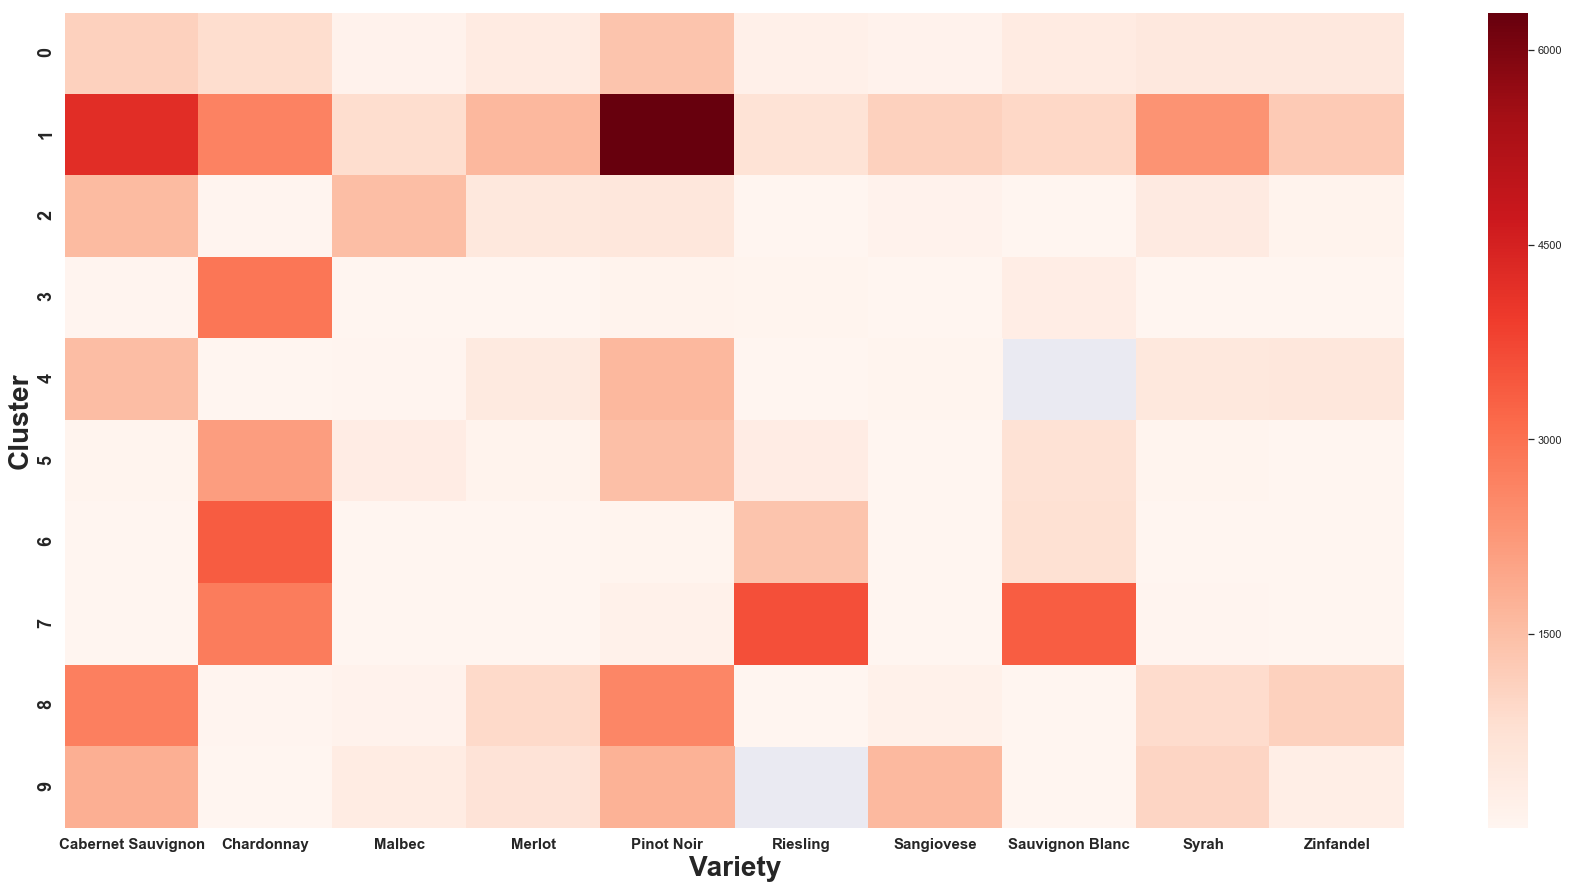

In [34]:
# Reference: https://www.kaggle.com/kitakoj18/exploring-wine-descriptions-with-nlp-and-kmeans?scriptVersionId=2224953
clusters = data.groupby(['cluster', 'variety']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('Variety', fontdict = {'weight': 'bold', 'size': 28})
ax2.set_ylabel('Cluster', fontdict = {'weight': 'bold', 'size': 28})
for label in ax2.get_xticklabels():
    label.set_size(15)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(18)
    label.set_weight("bold")

# Making sense of our clustering method

* We now have a rough idea of how the these 10 wines are being described in terms of our model.  I would now like to take the top clusters for each variety and make sense of their respective buzz words.  I will eliminate common words such as: wine, nose, palate, ect. and use our model to create our own artificial sommelier!
* I will compare our buzzwords to what is on winefolly.com

# Cabernet Sauvignon

**Top Clusters:** 1, 8
<br>
<br>
**Buzz words:**
<br>
1 : fruit, wine, flavors, **cherry**, finish, oak, tannins, vineyard, red, aromas
  <br> 8 : **cherry**, flavors, **blackberry**, **dry**, tannins, **currant**, **sweet**, drink, wine, **soft**
  
  
**Artificial Sommelier:**
* **Primary Flavors:** Cherry, Blackberry, Currant
* **Taste Profile:** Sweet, Soft, Dry


## <font color="maroon">Wine Folly:</font>
The world’s most popular red wine is a natural cross between Cabernet Franc and Sauvignon Blanc that originated around Bordeaux, France. Wines are concentrated and age worthy.

https://winefolly.com/cabernet-sauvignon/


* **Primary Flavors:** Black Cherry, Black Currant, Cedar, Baking Spices, Graphite
<br>
* **Taste Profile:** Full Body, Dry, Medium-High Tannin, Medium Acidity, 13.5–15% ABV

# Chardonnay

**Top Clusters:** 3, 6 
<br>
<br>
**Buzz words:**
<br>
3 : **buttered**, **pineapple**, **toast**, **vanilla**, flavors, oak, **sweet**, acidity, **pineapples**, **rich**
  <br> 6 : **apple**, **pear**, green, flavors, palate, **lemon**, finish, aromas, **citrus**, wine
  

**Artificial Sommelier:**
* **Primary Flavors:** Apple, Pear, Citrus (Lemon), Buttered, Pineapple, Vanilla, Toast
* **Taste Profile:** Sweet, Rich 


## <font color="maroon">Wine Folly:</font>
One of the world's most popular grapes, Chardonnay is made in a wide range of styles from lean, sparkling Blanc de Blancs to rich, creamy white wines aged in oak.

https://winefolly.com/chardonnay/


* **Primary Flavors:** Yellow Apple, Starfruit, Pineapple , Vanilla, Butter
<br>
* **Taste Profile:** Medium Body, Dry, Low/None Tannin, Medium Acidity, 13.5–15% ABV

# Malbec

**Top Cluster:** 2
<br>
<br>
**Buzz words:**
<br>
2 : **berry**, aromas, **plum**, finish, **herbal**, flavors, palate, feels, red, notes

**Artificial Sommelier:**
* **Primary Flavors:** Berry, Plum, Herbal
* **Taste Profile:** None 


## <font color="maroon">Wine Folly:</font>
Argentina's most important variety came by way of France, where it's commonly called Côt (sounds like "coat"). Wines are loved for their lusty fruit flavors and smooth chocolatey finish.

https://winefolly.com/malbec/


* **Primary Flavors:** Red Plum, Blackberry, Vanilla, Tobacco, Cocoa
<br>
* **Taste Profile:** Full Body, Dry, Medium Tannin, Medium-Low Acidity, 13.5–15% ABV

# Merlot

**Top Clusters:** 1, 8 

**Buzz words:**
1 : fruit, wine, flavors, **cherry**, finish, oak, tannins, vineyard, red, aromas 
8 : **cherry**, flavors, **blackberry**, dry, tannins, **currant**, **sweet**, drink, wine, **soft**

**Artificial Sommelier:**

**Primary Flavors:** Cherry, Blackberry, Currant
**Taste Profile:** Sweet, Soft, Dry

## <font color="maroon">Wine Folly:</font>
Merlot is loved for it's boisterous black cherry flavors, supple tannins, and chocolatey finish. On the high end, it's often mistaken with Cabernet Sauvignon and commonly blended with it.

https://winefolly.com/merlot/


* **Primary Flavors:** Cherry, Plum, Chocolate, Bay Leaf, Vanilla
<br>
* **Taste Profile:** Medium-Full Body, Bone-Dry, Medium-High Tannin, Medium Acidity, 13.5–15% ABV

# Pinot Noir

**Top Clusters:** 1, 8, 9
<br>
<br>
**Buzz words:**
<br>
1 : fruit, wine, flavors, **cherry**, finish, oak, tannins, vineyard, red, aromas
  <br> 8 : **cherry**, flavors, **blackberry**, **dry**, tannins, **currant**, **sweet**, drink, wine, **soft**
  <br>
  9 : black, **cherry**, palate, aromas, tannins, nose, fruit, **plum**, **dark**, **spice** 
  
  
**Artificial Sommelier:**
* **Primary Flavors:** Cherry, Blackberry, Currant, Plum, Spice
* **Taste Profile:** Sweet, Soft, Dry, Dark
  

## <font color="maroon">Wine Folly:</font>
Pinot Noir is the world's most popular light-bodied red wine. It's loved for its red fruit, flower, and spice aromas that are accentuated by a long, smooth finish.

https://winefolly.com/pinot-noir/


* **Primary Flavors:** Cherry, Rasberry, Mushroom, Vanilla, Hibiscus
<br>
* **Taste Profile:** Medium Body, Dry, Medium Low Tannin, Medium-High Acidity, 11.5–13.5% ABV

# Riesling

**Top Clusters:** 6, 7
<br>
<br>
**Buzz words:**
<br>
6 : **apple**, **pear**, green, flavors, palate, **lemon**, finish, aromas, **citrus**, wine
<br>
7 : **citrus**, **lemon**, **lime**, flavors, palate, finish, **peach**, **acidity**, **grapefruit**, **dry**
  
  
**Artificial Sommelier:**
* **Primary Flavors:** Apple, Citrus (Lemon, Lime, Grapefruit), Peach, Pear
* **Taste Profile:** Acidity, Dry


## <font color="maroon">Wine Folly:</font>
An aromatic white variety that can produce white wines ranging in style from bone-dry to very sweet. Germany is the world's most important producer of Riesling.

https://winefolly.com/riesling/


* **Primary Flavors:** Lime, Green Apple, Beeswax, Jasmine, Petrol
<br>
* **Taste Profile:** Light Body, Off-Dry, Low/None Tannin, High Acidity, Under 10% ABV

# Sangiovese

**Top Cluster:** 9
<br>
<br>
**Buzz words:**
<br>
9 : black, **cherry**, palate, aromas, tannins, nose, fruit, **plum**, **dark**, **spice**
  
  
**Artificial Sommelier:**
* **Primary Flavors:** Cherry, Plum, Spice
* **Taste Profile:** Dark


## <font color="maroon">Wine Folly:</font>
Italy's most planted wine variety and the pride of the Tuscan regional wine, Chianti. Sangiovese is a sensitive grape that takes on different stylistic expressions based on where it grows.

https://winefolly.com/sangiovese/


* **Primary Flavors:** Cherry, Roasted Tomato, Oregano, Espresso, Sweet Balsamic
<br>
* **Taste Profile:** Medium-Full Body, Bone-Dry, Medium-High Tannin, Medium-High Acidity, 13.5–15% ABV

# Sauvignon Blanc

**Top Cluster:** 7
<br>
<br>
**Buzz words:**
<br>
7 : **citrus**, **lemon**, **lime**, flavors, palate, finish, **peach**, **acidity**, **grapefruit**, **dry**
  
**Artificial Sommelier:**
* **Primary Flavors:** Apple, Citrus (Lemon, Lime, Grapefruit), Peach
* **Taste Profile:** Acidity, Dry
<br>
<br>

## <font color="maroon">Wine Folly:</font>
A popular and unmistakable white that's loved for its "green" herbal flavors and sky high acidity. Sauvignon Blanc grows nearly everywhere and is produced in a variety of methods resulting in a wide that range from lean to bountiful.

https://winefolly.com/sauvignon-blanc/


* **Primary Flavors:** Gooseberry, Honeydew Melon, Grapefruit, White Peach, Passion Fruit
<br>
* **Taste Profile:** Medium-Light Body, Dry, Low/None Tannin, High Acidity, 11.5–13.5% ABV

# Syrah

**Top Clusters:** 1, 4, 9
<br>
<br>
**Buzz words:**
<br>
1 : fruit, wine, flavors, **cherry**, finish, oak, tannins, vineyard, red, aromas
<br>
4 : **cherries**, **blackberries**, **currants**, **raspberries**, **dry**, flavors, tannins, **cola**, **rich**, wine
<br>
9 : black, **cherry**, palate, aromas, tannins, nose, fruit, **plum**, **dark**, **spice**
  
  
**Artificial Sommelier:**
* **Primary Flavors:** Berries(Cherries, Blackberries, Raspberries), Plum, Currant, Spice, Cola
* **Taste Profile:** Dark, Rich, Dry


## <font color="maroon">Wine Folly:</font>
A rich, powerful, and sometimes meaty red wine that originated in the Rhône Valley of France. Syrah is the most planted grape of Australia where they call it Shiraz.

https://winefolly.com/syrah/


* **Primary Flavors:** Blueberry, Black Plum, Milk Chocolate, Tobacco, Green Peppercorn
<br>
* **Taste Profile:** Full Body, Dry, Medium-High Tannin, Medium Acidity, 13.5–15% ABV

# Zinfandel

**Top Clusters:** 1, 4, 8 
<br>
<br>
**Buzz words:**
<br>
1 : fruit, wine, flavors, **cherry**, finish, oak, tannins, vineyard, red, aromas
<br>
4 : **cherries**, **blackberries**, **currants**, **raspberries**, **dry**, flavors, tannins, **cola**, **rich**, wine
<br> 8 : **cherry**, flavors, **blackberry**, **dry**, tannins, **currant**, **sweet**, drink, wine, **soft**
  
  
**Artificial Sommelier:**
* **Primary Flavors:** Cherry, Berries(Blackberries, Cherries, Raspberies), Currant, Cola
* **Taste Profile:** Dry, Sweet, Soft, Rich



## <font color="maroon">Wine Folly:</font>
A fruit-forward-yet-bold red that's loved for its red fruit flavors and smoky exotic spice notes. Originally from Croatia and related to top Croatian grape, Plavic Mali.

https://winefolly.com/search/zinfandel


* **Primary Flavors:** Blackberry, Strawberry, Peach Preserves, Cinnamon, Sweet Tobacco
<br>
* **Taste Profile:** Medium-Full Body, Dry, Medium-High Tannin, Medium-Low Acidity, Over 15% ABV

# Random Forest:

#### Tuning the hyperparameters (n_estimators, max_depth, and min_samples_leaf:

| `n_estimators` | Test accuracy | 
|----------------|---------------|
| $10$           |        .47       |
|$50$          |        **.50**       |
| $100$          |        .48       |
| $300$          |        .49       |

| `max_depth` | `min_samples_leaf` | Training accuracy | Test accuracy | 
|-------------|--------------------|-------------------|---------------|
| $5$         |   $1$              |          .39         |      .39         |
| $5$         |   $5$              |          .39         |        .39       |
| $5$         |   $10$             |          .38         |        .38       |
| $5$         |   $15$             |         .40          |        .40       |
| $5$         |   $50$             |          .40         |         .39      |
| $15$        |   $1$              |           .53        |          .51     |
| $15$        |   $5$              |           .50        |        .50       |
| $15$        |   $10$             |          .49         |         .48      |
| $15$        |   $15$             |            .49       |          .48     |
| $15$        |   $50$             |         .48          |          .48     |
| $50$       |   $1$              |          .84         |          .63     |
| $50$       |   $5$              |         **.63**          |          **.61**     |
| $50$       |   $10$             |         .63          |          .61     |
| $50$       |   $15$             |          .59         |          .58     |
| $50$       |   $50$             |          .54         |         .54      |


**Optimal Hyperparameters:**
* n_estimators = 50
* max_depth = 50
* min_samples_leaf = 5
    

### Training the Optimal Model

In [35]:
rf = RandomForestClassifier(max_depth=50, min_samples_leaf=5, n_estimators=50)
rf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
print("Training accuracy: %0.6f" % accuracy_score(Y_train, rf.predict(X_train)))
print("Test accuracy: %0.6f" % accuracy_score(Y_test, rf.predict(X_test)))

Training accuracy: 0.637089
Test accuracy: 0.614050


**This classifier doesn't quite have the accuracy that the logistic regression has, so most of the analysis was done on the initial classifier.**

## Next Steps:

* It would be interesting to further tune the model to get better accuracy scores by playing around with the hyperparameters and introducing more feature variables.
* I would also like to experiment with removing varieties that get mixed up often.
* I want to see how hard it would be to only give weight to the buzz words in the clustering method, taking out words like nose, wine, palate ect. to get more accurate generalizations of how the wines taste.
* I could also look at the most common 15 or 20 words instead of 10 to see if I'm potentially missing any important buzz words that just barely didn't make the cut.